# Chargement des données depuis un geopackage

Seuls les chargeurs de données classiques et basiques sont implémentés dans la librairie *tracklib*. Si vous avez vos données stockées dans un format différent, il vous faut créer vous même votre chargeur avec si besoin la librairie adéquate.

Afin de charger les données pour une trace ou une collection de traces depuis une source de données, il faut gérer : le format de la donnée temporelles (i.e. timestamp) et le système de projection (i.e. crs) en plus du chargement proprement dit des observations.

Cet exemple rapide montre comment charger des données depuis un fichier geopackage avec la librairie *Fiona*

## Let's start by defining our environment

This task is only useful for the online notebook

In [1]:
import os
import sys

# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Imports

The following imports are necessary for all of the examples.

In [2]:
import fiona
import matplotlib.pyplot as plt
import tracklib as tkl

## Définition du système de référence

Les données sont dans le système de référence WGS84, le srid dans tracklib est donc le format 'GeoCoords' ou 'GEO'. Et les coordonnées des observations seront chargées avec la classe *GeoCoords*. Par exemple:

o = GeoCoords(6.569672, 45.19995, 0)

## Définition du format timestamp

Si vos données ont un attribut temporel, il faut spécifier le format avec la méthode *setReadFormat* comme ci dessous. Par défaut le format est : "2D/2M/4Y 2h:2m:2s"

In [3]:
# set format for timestamp
tkl.ObsTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")

## Chargement des données

La configuration est prête pour lancer le chargement des données.
Les données sont contenues dans le layer "Bois de Vincenne"

In [4]:
chemin = '/home/md_vandamme/5_DATA/OUTDOORVISION/Vincennes/Vincennes.gpkg'

collection = tkl.TrackCollection()

cpt = 1
with fiona.open(chemin, layer='Bois de Vincenne') as layer:
    for feature in layer:
        geom = feature['geometry']
        if geom.type == 'LineString':
            prop = feature.properties
            
            track_id = prop['track_id']
            trace = tkl.Track(track_id=track_id)
            
            coords = feature.geometry["coordinates"]
            for c in coords:
                time = tkl.ObsTime()
                point = tkl.Obs(tkl.GeoCoords(c[0], c[1], 0), time)
                trace.addObs(point)

            # Changement du système de référence: on projete en Lambert93
            trace.toProjCoords(2154)
            
            activity = prop['activity']
            if activity == 'walking' or activity == 'running':
                # on ajoute la trace 
                collection.addTrack(trace)
                cpt += 1
                if cpt%1200 == 0:
                    print (cpt)

        if cpt > 10000:
            break

print ("Nb traces:", collection.size()) # 8654

1200
2400
3600
4800
6000
7200
8400
9600
Nb traces: 10000


## Filtre des données sur une petite zone rectangulaire

On souhaite ne pas charger toutes les données, mais seulement les données dont l'emprise est définie par un rectangle donné. 

On définit donc une contrainte dont la forme est celle du rectangle. Elle sera utilisée un peu plus tard.

In [5]:
xMin = 657336
yMin = 6860189
xMax = 657890
yMax = 6860625

ll = tkl.ENUCoords(xMin, yMin)
ur = tkl.ENUCoords(xMax, yMax)
bbox = tkl.Rectangle(ll, ur)
constraintBBox = tkl.Constraint(shape = bbox, mode = tkl.MODE_INSIDE, type=tkl.TYPE_CUT_AND_SELECT)

Et on filtre la collection sur la zone

In [6]:
lakeCollection = constraintBBox.select(collection)
print ('Number of tracks near the lake: ' + str(lakeCollection.size()))

Number of tracks near the lake: 2832


## Exporter les données

Sauvegarder les données sous forme de fichier CSV individuels

In [7]:
csvpath = '/home/md_vandamme/outdoorvision/brut'
tkl.TrackWriter.writeToFiles(lakeCollection, csvpath, ext='csv', id_E=0,id_N=1,id_U=2,id_T=3,h=1, separator=";")

## Display

Text(0.5, 1.0, 'Dataset of raw tracks')

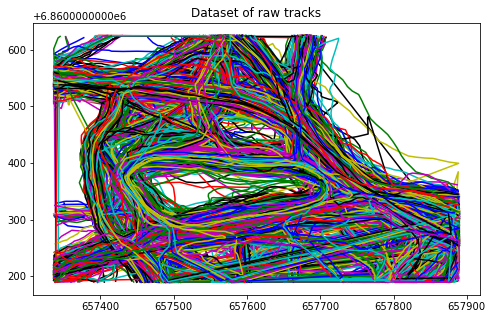

In [8]:
plt.figure(figsize=(8, 5))
lakeCollection.plot()
plt.title('Dataset of raw tracks')